# Experimentos de fluorescencia

## Introducción: Visualización ratiométrica de calcio con Fura-2

El **Fura-2** es el estándar para medir calcio intracelular en células vivas, gracias a su capacidad ratiométrica: permite distinguir cambios reales de \[Ca²⁺] incluso en condiciones experimentales subóptimas (desigual carga, fotodegradación, heterogeneidad celular, etc).

La señal se obtiene midiendo la fluorescencia a **340 nm** (indicador saturado con calcio) y **380 nm** (indicador libre), y trabajando con la **relación 340/380** (“ratio”), que responde directamente a la concentración de calcio.
Este enfoque minimiza artefactos y permite comparar entre regiones, células o ensayos, incluso cuando no se puede calcular la concentración absoluta (por falta de curva de calibración, buffers, etc.).

### ¿Qué vas a ver en este notebook?

El código procesa y visualiza experimentos de Fura-2 en células adherentes. Vas a encontrar:

* **Recortes y análisis de regiones**: Para comparar distintas zonas de la imagen (soma vs dendritas, o campo total vs ROIs).
* **Mapas espacio-temporales**: Promedios, máximos, desviación estándar y momento de activación de cada píxel a lo largo del tiempo.
  Esto permite detectar regiones activas, eventos espontáneos, y patrones propagados.
* **Kymographs**: Muestran la evolución de la intensidad a lo largo del tiempo en una línea o ROI.
* **Filtrado y reducción de ruido**: Técnicas como PCA, filtrado de fondo y suavizado temporal para revelar la dinámica real y eliminar artefactos.
* **Animaciones y videos**: Visualización dinámica del experimento, tanto en 2D como en 3D (superficie de intensidad por frame).
* **Comparaciones automáticas**: Entre señal cruda y señal procesada, para evaluar el impacto del filtrado.

### Aplicaciones y ejemplos

* **Dinámica de calcio inducida por estímulos** (ej: ATP, KCl, glutamato).
* **Comparación de condiciones experimentales** (control vs tratamiento).
* **Detección de eventos espontáneos o propagados** (flickers, ondas, etc).
* **Análisis comparativo entre regiones**: por ejemplo, diferencias en la respuesta entre soma y dendritas, o en zonas perinucleares vs periféricas.

### Ventajas de este enfoque computacional

* Permite **identificar artefactos** (fuga, bleaching, drift).
* Facilita la **automatización y cuantificación objetiva**.
* Es adaptable a cualquier formato de imagen (microscopía, placas, etc).
* Escalable a grandes volúmenes de datos (experimentos largos o con muchas células).


In [ ]:
import cv2 as cv
import numpy as np
import glob
import seaborn as sns  # Lo importamos aunque no lo usamos acá, seguro lo usás después

# === Función para cargar imágenes desde una carpeta ===
def load_images_to_array(path_pattern):
    """
    Carga imágenes de una carpeta (según patrón) y las convierte en un array de NumPy.
    """
    files = sorted(glob.glob(path_pattern))
    # Asume que todas las imágenes tienen las mismas dimensiones y tipo
    return np.array([cv.imread(file, cv.IMREAD_UNCHANGED) for file in files])

# --- Cargar las imágenes W1 y W2 ---
w1_img = load_images_to_array("E2 2h 6ulFURA si/E21.*")  # Ojo con la ruta: chequeá extensión
w2_img = load_images_to_array("E2 2h 6ulFURA si/E22.*")  # Lo mismo acá

# --- Control básico: las imágenes tienen que coincidir en dimensiones ---
if w1_img.shape == w2_img.shape:
    # División frame a frame, elemento a elemento, evitando divisiones por cero (te salva de NaN e inf)
    w1_w2 = np.divide(w1_img, w2_img, where=w2_img != 0)
else:
    raise ValueError("Las dimensiones de las imágenes en W1 y W2 no coinciden (¿copiaste mal la carpeta o se rompió algo?)")

# --- Info rápida del resultado (para que no te olvides qué generaste) ---
print(f'Información de la imagen W1/W2:')
print(f'frames: {w1_w2.shape[0]}, Y: {w1_w2.shape[1]}, X: {w1_w2.shape[2]}')
print(f'número de dimensiones: {w1_w2.ndim}, total de elementos: {w1_w2.size}, bytes por elemento: {w1_w2.itemsize}')


Información de la imagen W1/W2: frames: 222, Y: 256, X: 320
Número de dimensiones (ejes): 3, número total de elementos en el ndarray: 18186240, tamaño (en bytes) de cada elemento: 8


## Generación de las imágenes de un determinado frame

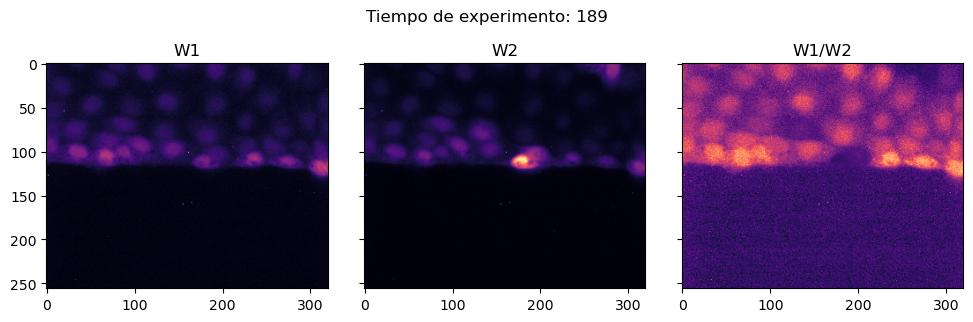

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# === Parámetro: qué frame ver ===
frame_visual = 189  # Cambiá este valor para ver otro frame

# === Paletas de color para cmap ===
temas_cmap = [
    'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'Blues',
    'Greens', 'Oranges', 'Reds', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
    'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot',
    'gist_heat', 'copper'
]
tema_seleccionado = temas_cmap[3]  # 'magma' de base (podés cambiarlo)

# --- Plot triple: W1, W2, W1/W2 ---
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))
fig.suptitle(f'Tiempo de experimento: {frame_visual}')

# W1
ax[0].set_title('W1')
ax[0].imshow(w1_img[frame_visual], cmap=tema_seleccionado)

# W2
ax[1].set_title('W2')
ax[1].imshow(w2_img[frame_visual], cmap=tema_seleccionado)

# W1/W2
ax[2].set_title('W1/W2')
ax[2].imshow(w1_w2[frame_visual], cmap=tema_seleccionado)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Que los títulos no se pisen
plt.show()


# Si te tiran un “IndexError” con el frame, fijate la cantidad de frames en tus arrays.

# El tema de color lo cambiás en la línea de tema_seleccionado. Si después te pica el bichito, hacé un widget interactivo.

# Si tus imágenes tienen NaN o valores locos, algunos cmap te los van a mostrar negro total.

# Los títulos son más para orientarte; si vas a exportar las imágenes, podés sacarlos.

## Crear un recorte de una zona

En el caso de encontrar algo interesante, se puede recortar la zona en recuadros para ver en "más detalle" qué está pasando

Se debe recortar con los parámetro

```
x_min = 100
x_max = 150

y_min = 90
y_max = 150
```


Información de la imagen W1/W2: frames: 222, Y: 50, X: 60
Número de dimensiones (ejes): 3, número total de elementos en el ndarray: 666000, tamaño (en bytes) de cada elemento: 8


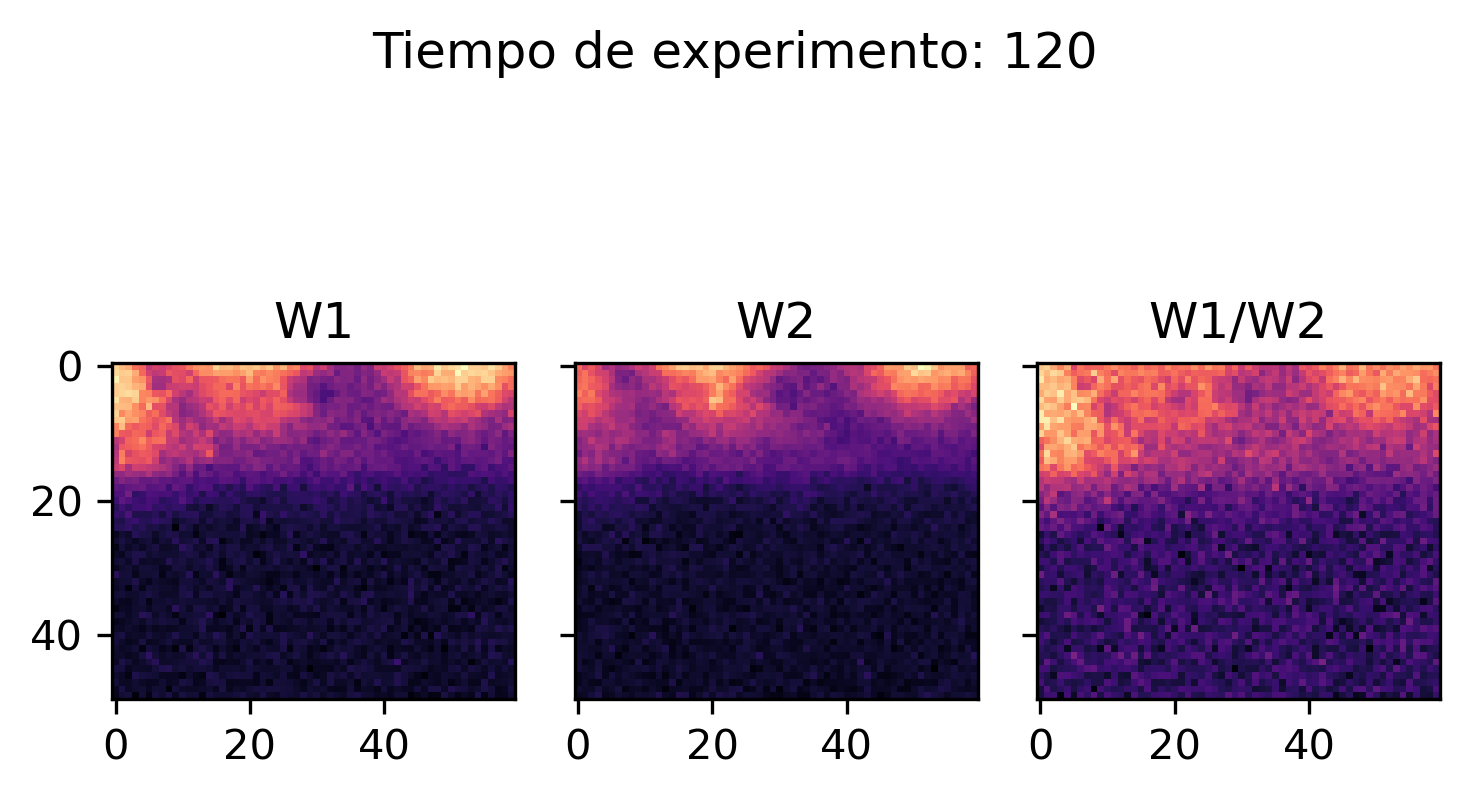

In [ ]:
# --- IMPORTS ---
import cv2 as cv
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# --- PARÁMETROS: frame y recorte ---
frame_visual = 120  # Cambiá esto si querés otro frame

# Rangos de recorte (ajustá si querés otra región)
x_min, x_max = 100, 150
y_min, y_max = 90, 150

# --- RECORTE DE IMÁGENES ---
# Ojo: asume que w1_img y w2_img ya están cargadas
w1_img_recorte = w1_img[:, x_min:x_max, y_min:y_max]
w2_img_recorte = w2_img[:, x_min:x_max, y_min:y_max]

# --- DIVISIÓN (siempre controlá dimensiones) ---
if w1_img_recorte.shape == w2_img_recorte.shape:
    w1_w2_recorte = np.divide(w1_img_recorte, w2_img_recorte, where=w2_img_recorte != 0)
else:
    raise ValueError("Las dimensiones de las imágenes en W1 y W2 no coinciden (probá revisando el recorte o el origen)")

# --- INFO DEL RESULTADO ---
print(f'Información de la imagen W1/W2 recortada:')
print(f'frames: {w1_w2_recorte.shape[0]}, Y: {w1_w2_recorte.shape[1]}, X: {w1_w2_recorte.shape[2]}')
print(f'dimensiones: {w1_w2_recorte.ndim}, total de elementos: {w1_w2_recorte.size}, bytes por elemento: {w1_w2_recorte.itemsize}')

# --- PLOTEO ---
temas_cmap = [
    'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'Blues',
    'Greens', 'Oranges', 'Reds', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
    'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot',
    'gist_heat', 'copper'
]
tema_seleccionado = temas_cmap[3]  # 'magma' (default, cambialo si pinta)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 3), dpi=300)
fig.suptitle(f'Tiempo de experimento: {frame_visual}')
ax[0].set_title('W1')
ax[0].imshow(w1_img_recorte[frame_visual], cmap=tema_seleccionado)
ax[1].set_title('W2')
ax[1].imshow(w2_img_recorte[frame_visual], cmap=tema_seleccionado)
ax[2].set_title('W1/W2')
ax[2].imshow(w1_w2_recorte[frame_visual], cmap=tema_seleccionado)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


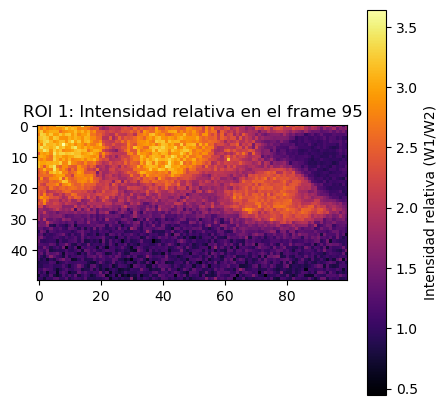

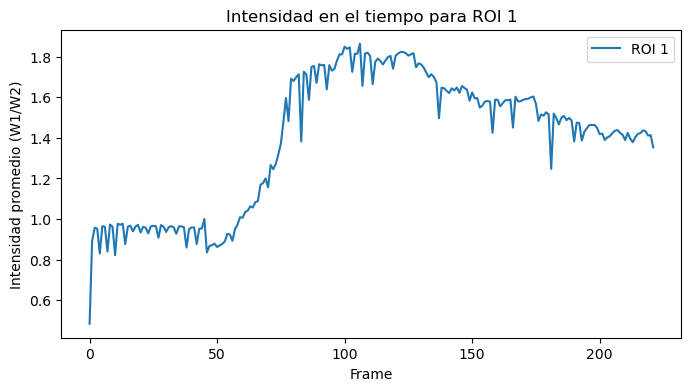

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Coordenadas de las ROIs donde aparecen los "flickers" ---
# Formato: (x, y, ancho, alto)
rois = [(100, 90, 100, 50)]
frame = 95  # Elegí el frame que te interesa mirar

for i, (x, y, w, h) in enumerate(rois):
    # --- 1. Recorte espacial y visualización de la ROI en un frame ---
    roi = w1_w2[frame, y:y+h, x:x+w]
    plt.figure(figsize=(5, 5))
    plt.imshow(roi, cmap='inferno')
    plt.colorbar(label='Intensidad relativa (W1/W2)')
    plt.title(f'ROI {i+1}: Intensidad relativa (frame {frame})')
    plt.show()
    
    # --- 2. Variación temporal: intensidad promedio en esa ROI ---
    intensidades_tiempo = np.mean(w1_w2[:, y:y+h, x:x+w], axis=(1, 2))
    plt.figure(figsize=(8, 4))
    plt.plot(intensidades_tiempo, label=f'ROI {i+1}')
    plt.title(f'Intensidad temporal en ROI {i+1}')
    plt.xlabel('Frame')
    plt.ylabel('Intensidad promedio (W1/W2)')
    plt.legend()
    plt.show()


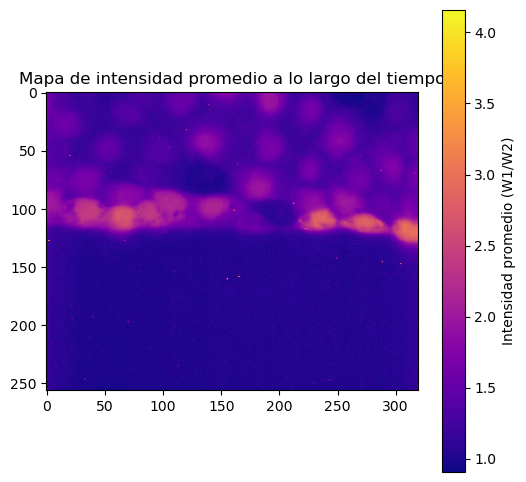

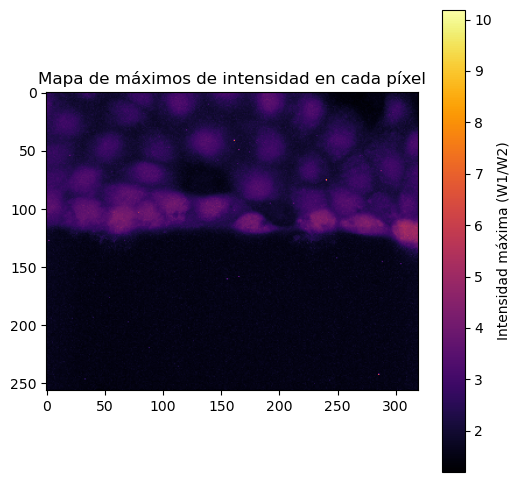

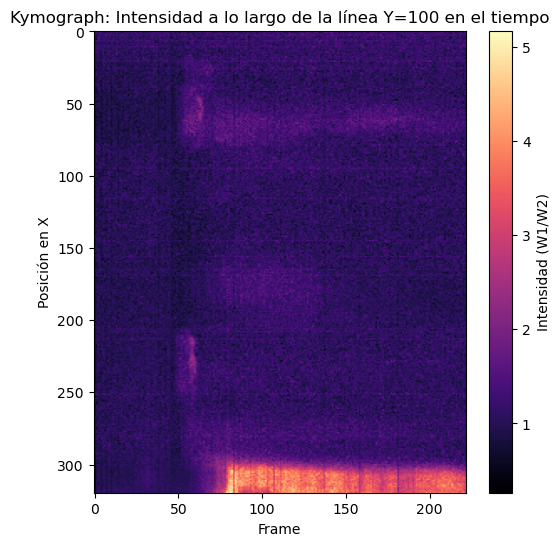

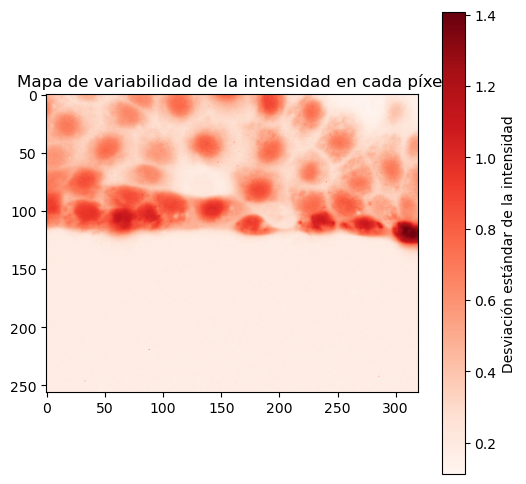

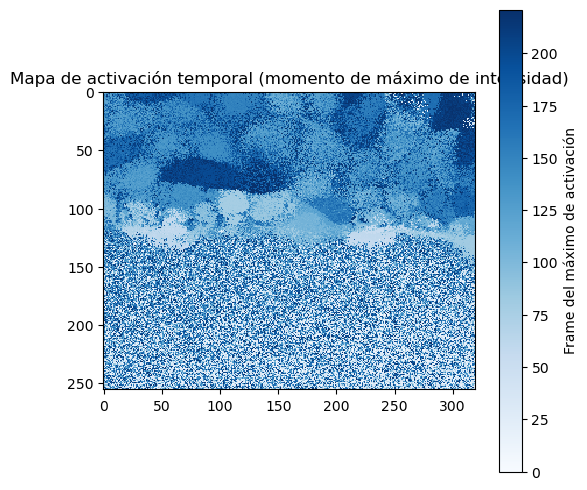

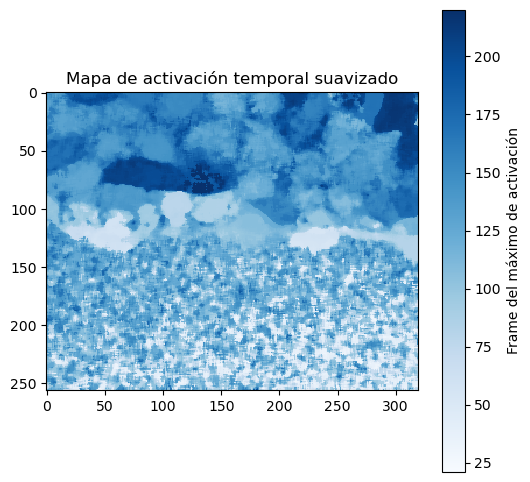

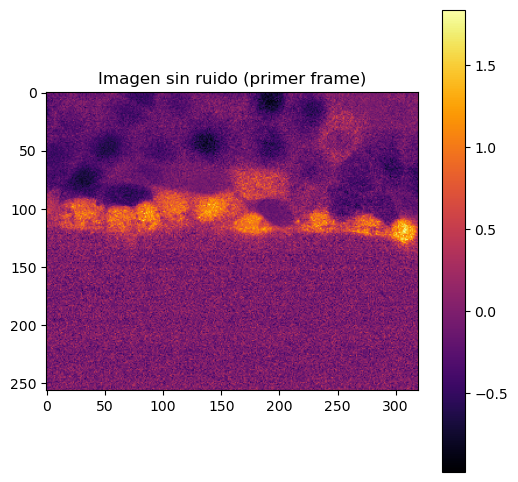

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# === MAPAS TEMPORALES ===

# Promedio en el tiempo: te muestra el "fondo" promedio por píxel
mapa_intensidad = np.mean(w1_w2, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(mapa_intensidad, cmap='plasma')
plt.colorbar(label='Intensidad promedio (W1/W2)')
plt.title('Mapa de intensidad promedio a lo largo del tiempo')
plt.show()

# Máximo en el tiempo: destaca los eventos "pico"
mapa_maximos = np.max(w1_w2, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(mapa_maximos, cmap='inferno')
plt.colorbar(label='Intensidad máxima (W1/W2)')
plt.title('Mapa de máximos de intensidad en cada píxel')
plt.show()

# === ANÁLISIS DE LÍNEA: KYMOGRAPH ===

# Línea horizontal en y=125 (ajustá el índice si querés otra)
linea_flicker = w1_w2[:, 125, :]  # shape: (frames, X)

plt.figure(figsize=(6, 6))
plt.imshow(linea_flicker.T, aspect='auto', cmap='magma')
plt.colorbar(label='Intensidad (W1/W2)')
plt.title('Kymograph: Intensidad a lo largo de la línea Y=125 en el tiempo')
plt.xlabel('Frame')
plt.ylabel('Posición en X')
plt.show()

# === MAPAS DE VARIABILIDAD ===

# Desviación estándar en el tiempo: zonas con más "ruido" o actividad
mapa_desviacion = np.std(w1_w2, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(mapa_desviacion, cmap='Reds')
plt.colorbar(label='Desviación estándar de la intensidad')
plt.title('Mapa de variabilidad de la intensidad en cada píxel')
plt.show()

# === MAPAS DE ACTIVACIÓN TEMPORAL ===

# En qué frame ocurre el máximo para cada píxel
mapa_activacion_temporal = np.argmax(w1_w2, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(mapa_activacion_temporal, cmap='Blues', interpolation='none')
plt.colorbar(label='Frame del máximo de activación')
plt.title('Mapa de activación temporal (momento de máximo de intensidad)')
plt.show()

# Suavizado con filtro de mediana para limpiar saltos aislados
mapa_activacion_suavizado = median_filter(mapa_activacion_temporal, size=5)

plt.figure(figsize=(6, 6))
plt.imshow(mapa_activacion_suavizado, cmap='Blues', interpolation='none')
plt.colorbar(label='Frame del máximo de activación')
plt.title('Mapa de activación temporal suavizado')
plt.show()

# === CORRECCIÓN DE FONDO (ELIMINAR "RUIDO") ===

# Promedio de fondo: te saca el bias estacionario de cada píxel
fondo_promedio = np.mean(w1_w2, axis=0)
w1_w2_sin_ruido = w1_w2 - fondo_promedio

# Visualizar algún frame después de sacar el fondo
plt.figure(figsize=(6, 6))
plt.imshow(w1_w2_sin_ruido[90], cmap='inferno')
plt.title('Imagen sin ruido (frame 90)')
plt.colorbar()
plt.show()


In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np

# --- Parámetros básicos ---
nombre_video = "E2 2h FURA"
velocidad = 24  # FPS
contraste = 1.0
saturacion = 1.0
res_ratio = 1.25
ancho_video = 1200
alto_video = int(ancho_video / res_ratio)

# --- Generación de frames para el video ---
imagenes_animacion = []
print('Inicio de generación del video normal W1/W2')

for i in range(w1_w2.shape[0]):
    # Opción: podés suavizar la imagen con median_filter antes de mostrarla si hay mucho ruido
    
    fig, ax = plt.subplots(figsize=(3.20, 2.56), dpi=96)
    ax.set_axis_off()
    ax.imshow(w1_w2[i], cmap='inferno')
    ax.text(0.05, 0.95, f'Frame: {i}', transform=ax.transAxes, fontsize=6, color='w')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.canvas.draw()
    imagen = np.array(fig.canvas.renderer._renderer)
    imagenes_animacion.append(imagen)
    plt.close(fig)

print('Fin de generación de los frames, guardando video...')

# --- Guardar como video MP4 usando imageio y ffmpeg ---
imageio.mimsave(
    f'{nombre_video}.mp4',
    imagenes_animacion,
    fps=velocidad,
    codec="libx265",
    quality=10,
    macro_block_size=None,
    ffmpeg_params=[
        "-vf", f"eq=contrast={contraste}:saturation={saturacion},scale={ancho_video}:{alto_video},pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-b:v", "5M",
        "-movflags", "faststart"
    ]
)

print('Video optimizado generado.')


Inicio de generación del video normal W1/W2


x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 10.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-4 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(15 rows)
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57 / 2 / 3
x265 [info]: Keyframe min / max / scenecut / bias  : 24 / 250 / 40 / 5.00 
x265 [info]: Lookahead / bframes / badapt        : 20 / 4 / 2
x265 [info]: b-pyramid / weightp / weightb       : 1 / 1 / 0
x265 [info]: References / ref-limit  cu / depth  : 3 / off / on
x265 [info]: AQ: mode / str / qg-size / cu-tree  : 2 / 1.0 / 32 / 1
x265 [info]: Rate Control / qCompress       

Fin de generación del video optimizado


x265 [info]: frame I:      6, Avg QP:25.02  kb/s: 9040.48 
x265 [info]: frame P:     52, Avg QP:26.25  kb/s: 6781.64 
x265 [info]: frame B:    164, Avg QP:28.42  kb/s: 5045.42 
x265 [info]: Weighted P-Frames: Y:32.7% UV:32.7%
x265 [info]: consecutive B-frames: 24.1% 0.0% 5.2% 10.3% 60.3% 

encoded 222 frames in 12.78s (17.38 fps), 5560.08 kb/s, Avg QP:27.82


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import imageio

# --- PCA sobre la secuencia de imágenes ---

n_frames, height, width = w1_w2.shape
w1_w2_reshaped = w1_w2.reshape(n_frames, -1)  # Cada frame como vector

# Ajustar número de componentes PCA según cuánto ruido querés filtrar
n_componentes = 10
pca = PCA(n_components=n_componentes)
w1_w2_pca = pca.fit_transform(w1_w2_reshaped)

# Reconstrucción desde PCA
w1_w2_reconstruido = pca.inverse_transform(w1_w2_pca)
w1_w2_sin_ruido = w1_w2_reconstruido.reshape(n_frames, height, width)

# --- GENERACIÓN DEL VIDEO ---

nombre_video = "E2 2h FURA (PCA)"
velocidad = 24  # FPS
contraste = 1.0
saturacion = 1.0
res_ratio = 1.25
ancho_video = 1200
alto_video = int(ancho_video / res_ratio)

imagenes_animacion = []
print('Inicio de generación del video con PCA aplicado W1/W2')

for i in range(n_frames):
    fig, ax = plt.subplots(figsize=(3.20, 2.56), dpi=96)
    ax.set_axis_off()
    ax.imshow(w1_w2_sin_ruido[i], cmap='inferno')
    ax.text(0.05, 0.95, f'Frame: {i}', transform=ax.transAxes, fontsize=6, color='w')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.canvas.draw()
    imagen = np.array(fig.canvas.renderer._renderer)
    imagenes_animacion.append(imagen)
    plt.close(fig)

print('Frames generados, guardando video...')

imageio.mimsave(
    f'{nombre_video}.mp4',
    imagenes_animacion,
    fps=velocidad,
    codec="libx265",
    quality=10,
    macro_block_size=None,
    ffmpeg_params=[
        "-vf", f"eq=contrast={contraste}:saturation={saturacion},scale={ancho_video}:{alto_video},pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-b:v", "5M",
        "-movflags", "faststart"
    ]
)

print('Fin de generación del video optimizado.')


Inicio de generación del video con PCA aplicado W1/W2


x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 10.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-4 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(15 rows)
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57 / 2 / 3
x265 [info]: Keyframe min / max / scenecut / bias  : 24 / 250 / 40 / 5.00 
x265 [info]: Lookahead / bframes / badapt        : 20 / 4 / 2
x265 [info]: b-pyramid / weightp / weightb       : 1 / 1 / 0
x265 [info]: References / ref-limit  cu / depth  : 3 / off / on
x265 [info]: AQ: mode / str / qg-size / cu-tree  : 2 / 1.0 / 32 / 1
x265 [info]: Rate Control / qCompress       

Fin de generación del video optimizado


x265 [info]: frame I:      1, Avg QP:24.92  kb/s: 4299.07 
x265 [info]: frame P:     55, Avg QP:11.48  kb/s: 11593.78
x265 [info]: frame B:    166, Avg QP:16.08  kb/s: 2492.54 
x265 [info]: Weighted P-Frames: Y:36.4% UV:30.9%
x265 [info]: consecutive B-frames: 8.9% 7.1% 5.4% 35.7% 42.9% 

encoded 222 frames in 9.09s (24.42 fps), 4755.49 kb/s, Avg QP:14.98


In [ ]:
from moviepy.editor import VideoFileClip, clips_array

# --- Cargar videos ---
video1 = VideoFileClip("E2 2h FURA.mp4")
video2 = VideoFileClip("E2 2h FURA (PCA).mp4")

nombre_video_comb = "E2 2h FURA"

# --- Asegurarse de igual duración (importante si hay frames de más) ---
min_duration = min(video1.duration, video2.duration)
video1 = video1.subclip(0, min_duration)
video2 = video2.subclip(0, min_duration)

# --- Combinar los dos videos lado a lado ---
video_combinado = clips_array([[video1, video2]])

# --- Guardar el video combinado ---
video_combinado.write_videofile(
    f"{nombre_video_comb} con y sin ruido.mp4",
    codec="libx265"
)


Moviepy - Building video E2 2h FURA con y sin ruido.mp4.
Moviepy - Writing video E2 2h FURA con y sin ruido.mp4



Moviepy - Done !
Moviepy - video ready E2 2h FURA con y sin ruido.mp4


## Video en 3D

La visualización en 3D no necesariamente aporta mucho, puede ser lo contrario

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
from sklearn.decomposition import PCA

# --- Parámetros de entrada ---
nombre_video = "E2 2h FURA sin ruido"
mapa_color = 'inferno'
n_components = 10
velocidad = 24  # FPS
res_ratio = 1.25
ancho_video = 1024
alto_video = int(ancho_video / res_ratio)
contraste = 1.0
saturacion = 1.0

# --- PCA y reconstrucción ---
n_frames, height, width = w1_w2.shape
w1_w2_reshaped = w1_w2.reshape(n_frames, -1)
pca = PCA(n_components=n_components)
w1_w2_pca = pca.fit_transform(w1_w2_reshaped)
w1_w2_reconstruido = pca.inverse_transform(w1_w2_pca)
w1_w2_sin_ruido = w1_w2_reconstruido.reshape(n_frames, height, width)

# --- Generación de animación 3D ---
imagenes_animacion_3d = []
print('Comienzo de generación del video 3D W1/W2 (PCA)')

for i in range(n_frames):
    img = w1_w2_sin_ruido[i]
    fig = plt.figure(figsize=(5, 5), dpi=96)
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.set_axis_off()

    # malla de coordenadas
    x = np.arange(img.shape[1])
    y = np.arange(img.shape[0])
    x_mesh, y_mesh = np.meshgrid(x, y)

    # superficie
    ax.plot_surface(x_mesh, y_mesh, img, cmap=mapa_color, linewidth=0, antialiased=False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensidad')
    ax.view_init(elev=60, azim=145)

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout()
    fig.canvas.draw()
    imagen = np.array(fig.canvas.renderer._renderer)
    imagenes_animacion_3d.append(imagen)
    plt.close(fig)

print('Frames 3D generados, guardando video...')

io.mimsave(
    f'{nombre_video}_3D.mp4',
    imagenes_animacion_3d,
    fps=velocidad,
    codec="libx265",
    quality=10,
    macro_block_size=None,
    ffmpeg_params=[
        "-vf", f"eq=contrast={contraste}:saturation={saturacion},scale={ancho_video}:{alto_video},pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-b:v", "5M",
        "-movflags", "faststart"
    ]
)
print('Fin de generación del video optimizado.')


Comienzo de generación del video 3D W1/W2 con las intensidades máximas


x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 10.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-3.1 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(13 rows)
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57 / 2 / 3
x265 [info]: Keyframe min / max / scenecut / bias  : 24 / 250 / 40 / 5.00 
x265 [info]: Lookahead / bframes / badapt        : 20 / 4 / 2
x265 [info]: b-pyramid / weightp / weightb       : 1 / 1 / 0
x265 [info]: References / ref-limit  cu / depth  : 3 / off / on
x265 [info]: AQ: mode / str / qg-size / cu-tree  : 2 / 1.0 / 32 / 1
x265 [info]: Rate Control / qCompress     

Fin de generación del video optimizado


x265 [info]: frame I:      1, Avg QP:16.93  kb/s: 7673.66 
x265 [info]: frame P:     56, Avg QP:11.35  kb/s: 7989.93 
x265 [info]: frame B:    165, Avg QP:15.31  kb/s: 3520.42 
x265 [info]: Weighted P-Frames: Y:16.1% UV:16.1%
x265 [info]: consecutive B-frames: 5.3% 15.8% 7.0% 28.1% 43.9% 

encoded 222 frames in 6.94s (31.99 fps), 4666.57 kb/s, Avg QP:14.32


In [ ]:
import imageio as io
import matplotlib.pyplot as plt
import numpy as np

imagenes_animacion_3d = []
mapa_color = 'inferno'

print('Comienzo de generación del video 3D W1/W2')

for i in range(w1_w2.shape[0]):
    img = w1_w2[i]
    fig = plt.figure(figsize=(5, 5), dpi=96)
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.set_axis_off()
    x, y = np.arange(img.shape[1]), np.arange(img.shape[0])
    x_mesh, y_mesh = np.meshgrid(x, y)
    ax.plot_surface(x_mesh, y_mesh, img, cmap=mapa_color, linewidth=0, antialiased=False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensidad')
    ax.view_init(elev=60, azim=145)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout()
    fig.canvas.draw()
    imagen = np.array(fig.canvas.renderer._renderer)
    imagenes_animacion_3d.append(imagen)
    plt.close(fig)

# --- Parámetros de salida ---
nombre_video = "E2 2h FURA"  # Poné el nombre que corresponda
res_ratio = 1.25
ancho_video = 1024
alto_video = int(ancho_video / res_ratio)
velocidad = 24  # FPS

# --- Guardar animación como video mp4 ---
io.mimsave(
    f'{nombre_video}_3D.mp4',
    imagenes_animacion_3d,
    fps=velocidad,
    codec="libx265",
    quality=10,
    macro_block_size=None,
    ffmpeg_params=[
        "-vf", f"eq=contrast=1.25:saturation=1.15,scale={ancho_video}:{alto_video},pad=ceil(iw/2)*2:ceil(ih/2)*2",
        "-b:v", "5M",
        "-movflags", "faststart"
    ]
)

print('Fin de generación del video optimizado.')
